# Classification

In many situations the response we are interested in is _qualitative_ rather than _quantitative_.

Predicting a qualitative response typically involves assigning the observation to a category, hence
"classifying" that observation.

## Logistic regression

Logistic regression is a simple statistical model which may be used to classify observations into
one of two distinct categories. Let's introduce it through example.

Consider the breast cancer data from the `sklearn` package:


In [6]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

cancer = load_breast_cancer(as_frame=True)
X_train, y_train = cancer.data, cancer.target

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


The data relates 30 predictor variables to a tumour that was determined malignant or benign,
(encoded as 0 or 1).

Logistic regression involves fitting a model:

$$
\log\left(\frac{\pi(X)}{1 - \pi(X)}\right) = \beta_0 + \beta X
$$

where $\pi(X)$ is the probability $Pr(Y = 1\,\vert\,X)$. 

We can use a `Pipeline` to preprocess and fit in one go:

In [15]:
model = Pipeline(
    [
        ("pre", StandardScaler()),
        ("logis", LogisticRegression()),
    ]
)
model.fit(X_train, y_train)

,steps,"[('pre', ...), ('logis', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


## Quantifying error

To consider the performance of a classifier we may consider the measures:

1. **Accuracy**: The proportion of correct classifications made by the model.

2. **Precision**: The proportion of correct positive classifications of those predicted as positive.

   Computed as 
   $$
     \frac{t_p}{(t_p + f_p)},
   $$ 

   where:

   - $t_p$ is the number of _true positives_ and,

   - $f_p$ the number of _false positives_.

   Intuitively, the precision is:

   > the ability of the classifier not to label as positive a sample that is negative.

3. **Recall**: The proportion of correct positive classifications of those that were truly positive
   in the reference data.

   Computed as
   $$
     \frac{t_p}{(t_p + f_n)}
   $$
  
   where:
   - $t_p$ is the number of true positives and,
    
   - $f_n$ the number of false negatives. 
     
   Intuitively, the recall is:
  
   > the ability of the classifier to find all the positive samples.

`sklearn.metrics` implements the above measures:


In [16]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
)

y_pred = model.predict(X_train)
print(
    "The accuracy score of this model fit is:",
    accuracy_score(y_train, y_pred)
)
print(
    "The precision score of this model fit is:",
    precision_score(y_train, y_pred, pos_label=0),
)
print(
    "The recall score of this model fit is:",
    recall_score(y_train, y_pred, pos_label=0),
)

The accuracy score of this model fit is: 0.9876977152899824
The precision score of this model fit is: 0.9904306220095693
The recall score of this model fit is: 0.9764150943396226


Typically, we are not interested in the ability of our model to classify _the training data_.

Instead, we are interested in its performance on _unseen data_.

We can use cross validation to better assess model performance:


In [17]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
import pandas as pd

acc = make_scorer(accuracy_score)

def precision(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label=0)

def recall(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

prec = make_scorer(precision)
rec = make_scorer(recall)
output = cross_validate(
    model,
    X_train,
    y_train,
    scoring={"acc": acc, "prec": prec, "rec": rec},
    cv=10,
)

pd.DataFrame(output).mean()

fit_time      0.005265
score_time    0.005629
test_acc      0.980670
test_prec     0.986107
test_rec      0.962121
dtype: float64

## Decision trees

Decision trees aim to learn simple decision rules, to be used for classification, from data. 

This rule-based approach yields a model which is simple to understand and interpret.

### Intuition

Decision trees are found by recursively partitioning data.

The idea is to:

1. Search amongst the variables to find the point which "best splits" the data into two parts.

2. Repeat step 1. for each of these two new parts (recursing until some stopping criteria is met.)

We _could_ recursively partition the data until each observation is alone in a node,
but this would be a terrible case of over fitting.

Typically, we prune the tree by employing some penalty on complexity or having a terminating
condition based on the maximum allowed depth of the tree:


In [7]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

cancer = load_breast_cancer(as_frame=True)
X_train, y_train = cancer.data, cancer.target
cancer.target_names
type(X_train)
print(X_train.columns)

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')


In [8]:
import sklearn.tree as tree
from sklearn.metrics import ConfusionMatrixDisplay

model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


After fitting a model we can examine diagnostics such as a confusion matrix 

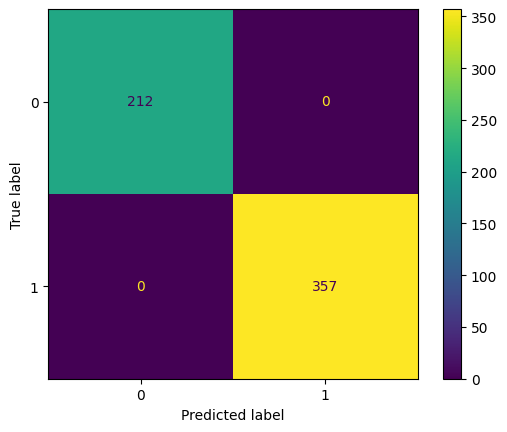

In [9]:
ConfusionMatrixDisplay.from_predictions(y_train, model.predict(X_train))

and cross validation estimates of performance metrics:


In [51]:
from sklearn.model_selection import cross_validate

val = cross_validate(model, X_train, y_train, cv=10)
val["test_score"].mean()

np.float64(0.9156641604010025)